In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

from data_utils import compare, split_series, resample_data, get_sequence_len
from model_utils import build_model

In [2]:
np.random.seed(42)
from tensorflow import keras as ks

In [3]:
# data paths
DATA_DIR = './data/'
DATA_FILE = 'data.pickle'
MODEL_DIR = './models/'

seconds_per_sequence = 15

In [4]:
with open(f'{DATA_DIR}{DATA_FILE}', 'rb') as data_file:
    data = pickle.load(data_file)

In [5]:
mask = compare(data[:, 0])
data = np.append(data, np.zeros(dtype='int32',shape=(data.shape[0], 1)), 1)
data[:, 4][mask] = 1

In [6]:
sec_len = get_sequence_len(seconds_per_sequence)

In [7]:
split_series_data = split_series(data, sec_len, 1)
series_data, targets = resample_data(split_series_data[0], split_series_data[1])

print(f'By now we have {series_data.shape[0]} time series with length {series_data.shape[1]}')

x_train, x_test, y_train, y_test = train_test_split( series_data, targets)

By now we have 4074 time series with length 240


In [8]:
model = build_model(sec_len, 2)

In [9]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[ks.metrics.BinaryAccuracy()],
)

In [10]:
callbacks = [
    ks.callbacks.ModelCheckpoint(
        f"{MODEL_DIR}best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    ks.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1),
]

In [11]:
history = model.fit(
    [
        x_train[:, :, 1].reshape(-1, sec_len, 1),
        x_train[:, :, 2].reshape(-1, sec_len, 1),
        x_train[:, :, 3].reshape(-1, sec_len, 1)
    ],
    ks.utils.to_categorical(y_train, 2),
    batch_size=8,
    epochs=40,
    validation_split=0.2,
    verbose=0,
    callbacks=callbacks,
    shuffle=True
)

In [12]:
prediction = np.argmax(
    model.predict([
        x_test[:, :, 1].reshape(-1, sec_len, 1),
        x_test[:, :, 2].reshape(-1, sec_len, 1),
        x_test[:, :, 3].reshape(-1, sec_len, 1)
]), axis=1)

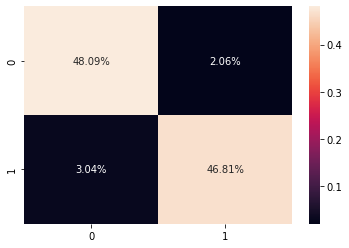

In [13]:
cf_matrix = confusion_matrix(y_true=y_test, y_pred=prediction)
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='.2%')
plt.show()

In [14]:
accuracy_score(y_true=y_test, y_pred=prediction)

0.9489695780176644